# Moving Average Trading System
Markets' data is imported from [yfinance API](https://github.com/ranaroussi/yfinance)

In [370]:
# Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [371]:
# Choosing instrument for an analysis: https://finance.yahoo.com/currencies
instrument = yf.Ticker("EURUSD=X")

In [372]:
# Importing OHLC info. Useful parameters:
# "period: data period to download (Either Use period parameter or use start and end) Valid periods are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
#  interval: data interval (intraday data cannot extend last 60 days) Valid intervals are: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo"

df = instrument.history(period='10y', interval='1d') # In this case daily time frame data is imported from past 10 years
df = df.reset_index()
df = df.set_index(pd.DatetimeIndex(df['Date'].dt.date))
df = df.drop(columns=['Date','Volume', 'Dividends', 'Stock Splits'])
df

,Open,High,Low,Close
Date,,,,
2012-12-17,1.316656,1.317969,1.314752,1.316586
2012-12-18,1.316482,1.321390,1.315738,1.316482
2012-12-19,1.323101,1.330690,1.322524,1.323101
2012-12-20,1.321353,1.329434,1.320603,1.321528
2012-12-21,1.323802,1.323802,1.316900,1.323767
...,...,...,...,...
2022-12-13,1.054174,1.066894,1.052931,1.054174
2022-12-14,1.062665,1.066985,1.062011,1.062665
2022-12-15,1.067635,1.072559,1.060738,1.067635


## Entry Strategy: 
Long position entry conditions:
1. Simple Moving Average Crossover - faster 20 day SMA crossing above slower 50 day SMA
2. Close price is above 100 day Exponential Moving Average

Short position entry conditions:
1. Simple Moving Average Crossover - faster 20 day SMA crossing underneath slower 50 day SMA
2. Close price is above 100 day Exponential Moving Average

In [373]:
df['SMA_faster']= df['Close'].rolling(window=20).mean()
df['SMA_slower']= df['Close'].rolling(window=50).mean()
df['EMA']= df['Close'].ewm(span=100).mean()

In [374]:
df['Signal'] = np.where((df['SMA_faster'] > df['SMA_slower']), 1, 0) # Finding ranges where faster SMA is above or below slower SMA
df['Position'] = df['Signal'].diff() # Finding exact spots where SMAs cross

# Putting Buy and Sell positions with checking if they are on a proper side of EMA.
df['Buy'] = np.where((df['Position'] == 1) & (df['Close'] > df['EMA']), df['Close'], np.NAN)
df['Sell'] = np.where((df['Position'] == -1) & (df['Close'] < df['EMA']) , df['Close'], np.NAN)

In [375]:
# Choose a "start" date for a plot
start = '2020-01-01'

df_subset = df.loc[start: df.index[-1]]

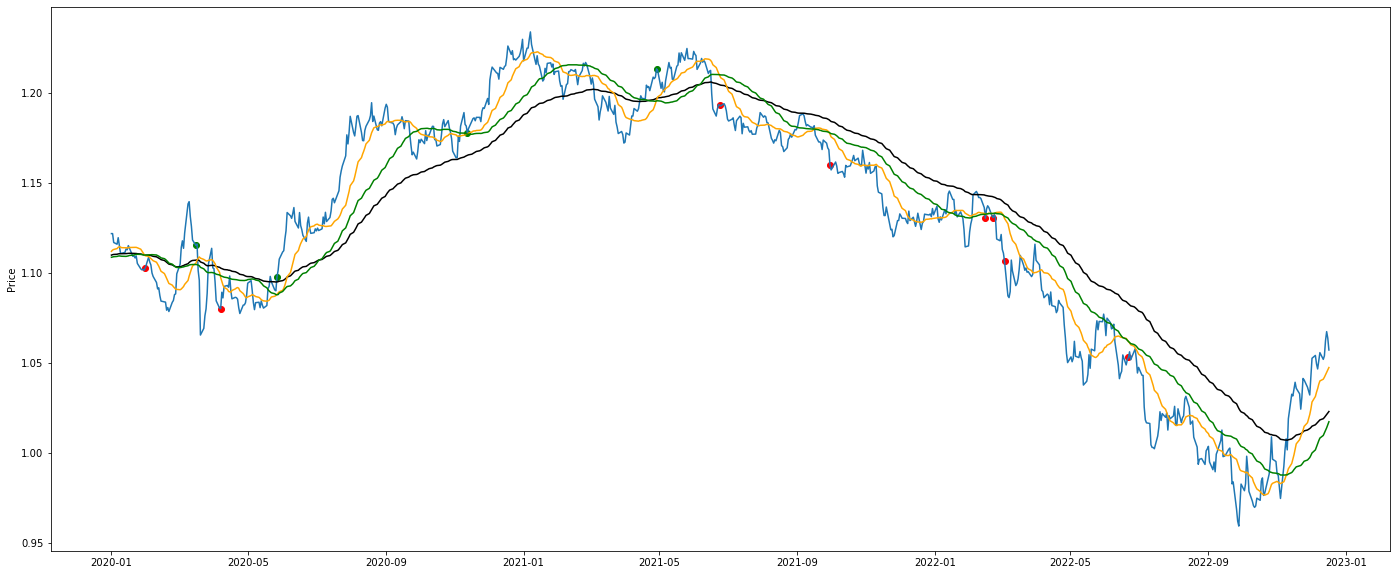

In [376]:
# Visualzing calculations made so far
plt.figure(figsize=(24,10))
plt.plot(df_subset['Close'])
plt.plot(df_subset['EMA'], color = 'black')
plt.plot(df_subset['SMA_faster'], color='orange')
plt.plot(df_subset['SMA_slower'], color = 'green')

# Red dots - short position signals; Green dots - long position signals
plt.scatter(df_subset.index, df_subset['Buy'], alpha = 1, label='Buy Signal', marker='o', color = 'green')
plt.scatter(df_subset.index, df_subset['Sell'], alpha = 1, label='Sell Signal', marker='o', color = 'red')
plt.ylabel('Price')
plt.show()

## Exit Strategy: 
Conditions for exiting the trade are based on ["Chandelier Exit indicator"](https://corporatefinanceinstitute.com/resources/equities/chandelier-exit/).

"CE is a volatility-based indicator that identifies stop loss exit points for long and short trading positions. Chandelier Exit is based on the [Average True Range (ATR) Formula](https://www.investopedia.com/terms/a/atr.asp)."


In [377]:
# Calculating 22day ATR value
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['ATR22'] = true_range.rolling(22).mean()

In [390]:
# Calculating two lines of Chandelier Exit indicator
highest_high = df['High'].rolling(window=22).max()
lowest_low = df['Low'].rolling(window=22).min()

df['chandelier_long'] = highest_high - df['ATR22'] * 4
df['chandelier_short'] = lowest_low + df['ATR22'] * 4

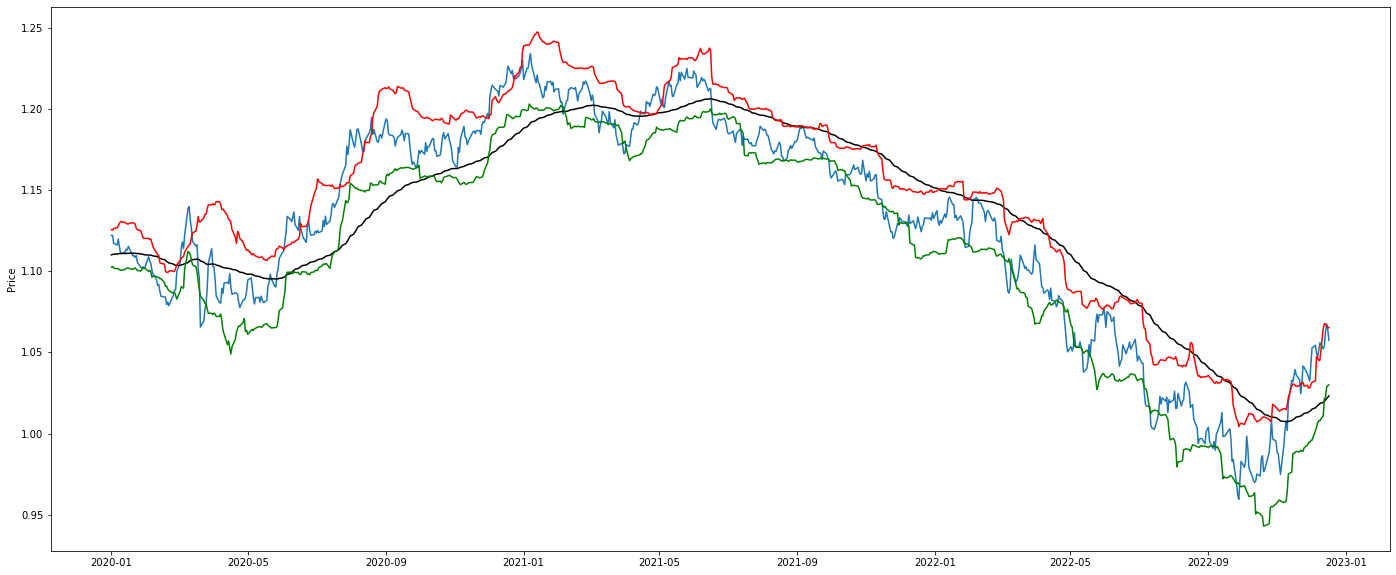

In [401]:
df_subset2 = df.loc[start: df.index[-1]]

# Visualzing Chandelier Exit lines
plt.figure(figsize=(24,10))
plt.plot(df_subset2['Close'])
plt.plot(df_subset2['EMA'], color = 'black')
plt.plot(df_subset2['chandelier_long'], color='green')
plt.plot(df_subset2['chandelier_short'], color = 'red')

plt.ylabel('Price')
plt.show()

Trade exit rules:
* Long position is closed when 'Close' price line crosses below 'Chandelier Exit Long' green line.
* Short position is closed when 'Close' price line crosses above 'Chandelier Exit Short' red  line.

In [414]:
# Finding long trades' exit spots
df['chand_long1'] = df['chandelier_long'] < df['Close']
df['chand_long2'] = df['chand_long1'].shift()
df['chand_long_final'] = (df['chand_long1'] == True) & (df['chand_long2'] == False)
df['long_exit'] = np.where(df['chand_long_final'] == True, df['Close'], np.NAN)
df = df.drop(columns=['chand_long1', 'chand_long2', 'chand_long_final'])

df['long_exit_final'] = np.NAN
df_long_exit_final_copy = df['long_exit_final'].copy()
df_long_exit_final_copy

for i in range(len(df)):
    if ~np.isnan(df['Buy'][i]):
        for j in range(i,len(df)):
            if ~np.isnan(df['long_exit'][j]):
                df_long_exit_final_copy[j] = df['long_exit'][j]
                break

df['long_exit_final'] = df_long_exit_final_copy

In [413]:
# Finding short trades' exit spots
df['chand_short1'] = df['chandelier_short'] > df['Close']
df['chand_short2'] = df['chand_short1'].shift()
df['chand_short_final'] = (df['chand_short1'] == True) & (df['chand_short2'] == False)
df['short_exit'] = np.where(df['chand_short_final'] == True, df['Close'], np.NAN)
df = df.drop(columns=['chand_short1', 'chand_short2', 'chand_short_final'])

df['short_exit_final'] = np.NAN
df_short_exit_final_copy = df['short_exit_final'].copy()
df_short_exit_final_copy

for i in range(len(df)):
    if ~np.isnan(df['Sell'][i]):
        for j in range(i,len(df)):
            if ~np.isnan(df['short_exit'][j]):
                df_short_exit_final_copy[j] = df['short_exit'][j]
                break
df['short_exit_final'] = df_short_exit_final_copy
    

## Summary
Trading system is designed to work with two accounts: one for short and one for long positions.

Visualizations below present results of the trading system working for last 3 years on EURUSD pair.

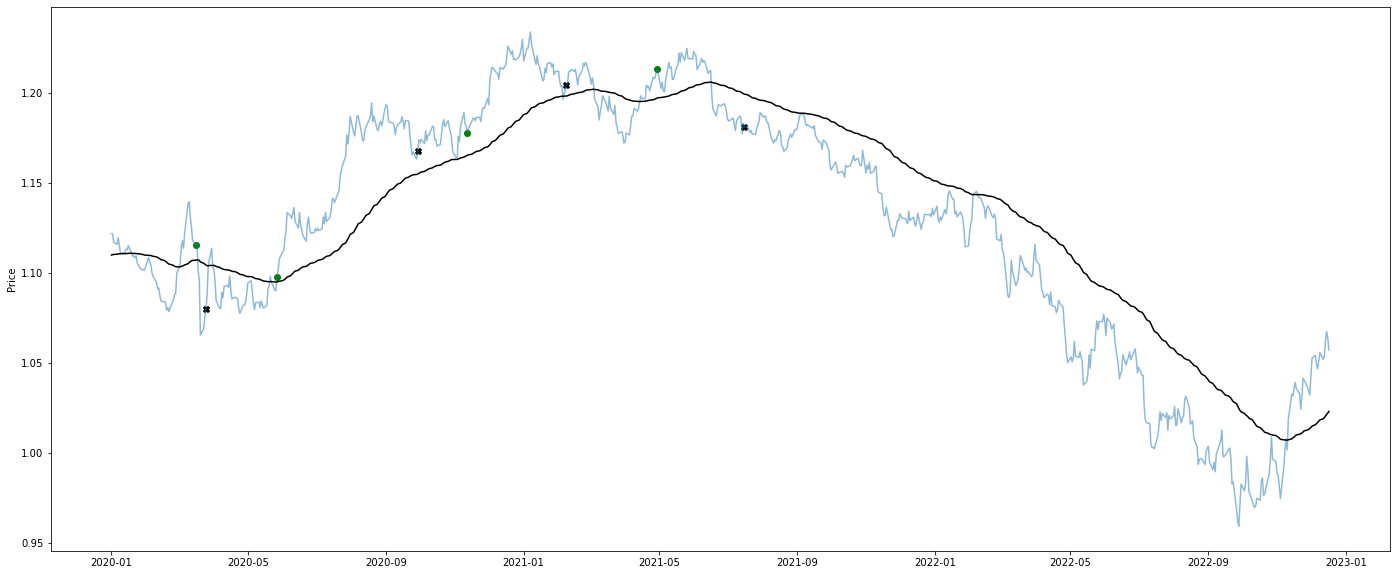

In [411]:
# Visualizing long postions
df_subset3 = df.loc[start: df.index[-1]]

plt.figure(figsize=(24,10))
plt.plot(df_subset3['Close'], alpha = 0.5)
plt.plot(df_subset3['EMA'], color = 'black')

# Green dots - long position entry signals
plt.scatter(df_subset3.index, df_subset3['Buy'], alpha = 1, label='Buy Signal', marker='o', color = 'green')

# X markers are trade exit signals
plt.scatter(df_subset3.index, df_subset3['long_exit_final'], alpha = 1, label='Long Exit', marker='X', color = 'black')

plt.ylabel('Price')
plt.show()

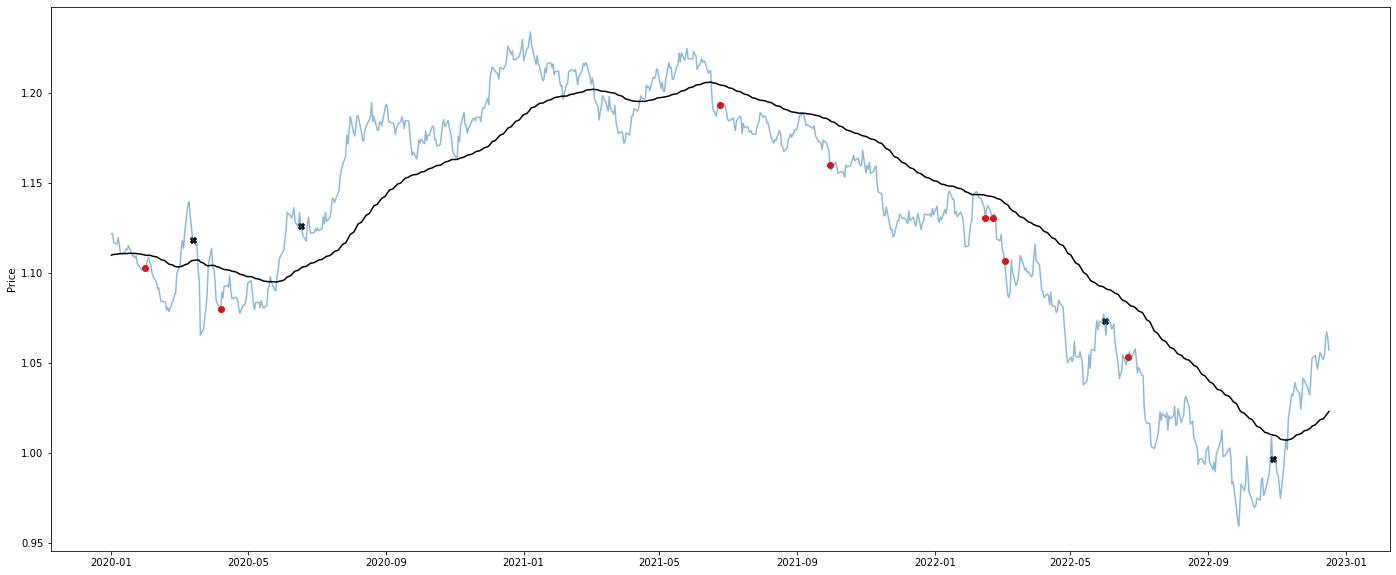

In [415]:
# Visualizing short postions
df_subset4 = df.loc[start: df.index[-1]]

plt.figure(figsize=(24,10))
plt.plot(df_subset4['Close'], alpha = 0.5)
plt.plot(df_subset4['EMA'], color = 'black')

# Red dots - short position entry signals
plt.scatter(df_subset4.index, df_subset4['Sell'], alpha = 1, label='Sell Signal', marker='o', color = 'red')

# X markers are trade exit signals
plt.scatter(df_subset4.index, df_subset4['short_exit_final'], alpha = 1, label='Short Exit', marker='X', color = 'black')

plt.ylabel('Price')
plt.show()

## Backtesting summary
TBC...